# FENEK OUARDA - OUERK SARA YASMINE 

## Distilling the knowledge of BERT for text generation 

**BERT for text generation and translation:**

Large-scale pre-trained language model, such as BERT, has recently achieved great success in a wide range of language understanding tasks. 
However, it remains an open question how to utilize BERT for text generation tasks. 

**Suggestion:**

An way to leverage BERT for text generation and translation is to initialize the parameters of the encoder
or decoder of Seq2Seq with pre-trained BERT, and then fine-tuning on the target dataset.

**Limitations:**

However, this approach requires the encoder/decoder to have the same size as BERT, inevitably making the
final text generation model too large. 



**Distilling the knowledge of BERT for text generation:**

In this approach we do not directly use the parameters of BERT in the Seq2Seq model. Instead, Bert acts as an effective regularization to the MLE trainig loss (Cross Entropy Loss), by proactively injecting future information for predecting the present. 

We will be distilling the knowledge learned in BERT for text generation tasks. 

We will first implement a Conditional Masked Language Modeling (C-MLM) task, inspired by MLM but requiring additional conditional input, which enables fine-tuning pre-trained BERT on a target dataset. 

In order to extract knowledge from the fine-tuned BERT and apply it to a text generation model, we leverage the fine-tuned BERT as a **teacher** model that generates sequences of word probability logits for the training samples, and treat the text generation model as a **student** network, which can effectively learn from the teacher’s outputs for imitation. 

The proposed approach improves text generation by providing a good estimation on the word probability distribution for each token in a sentence, **consuming both the left and the right context**, the exploitation of which encourages conventional text generation models to plan ahead.

**Insérer l'image**

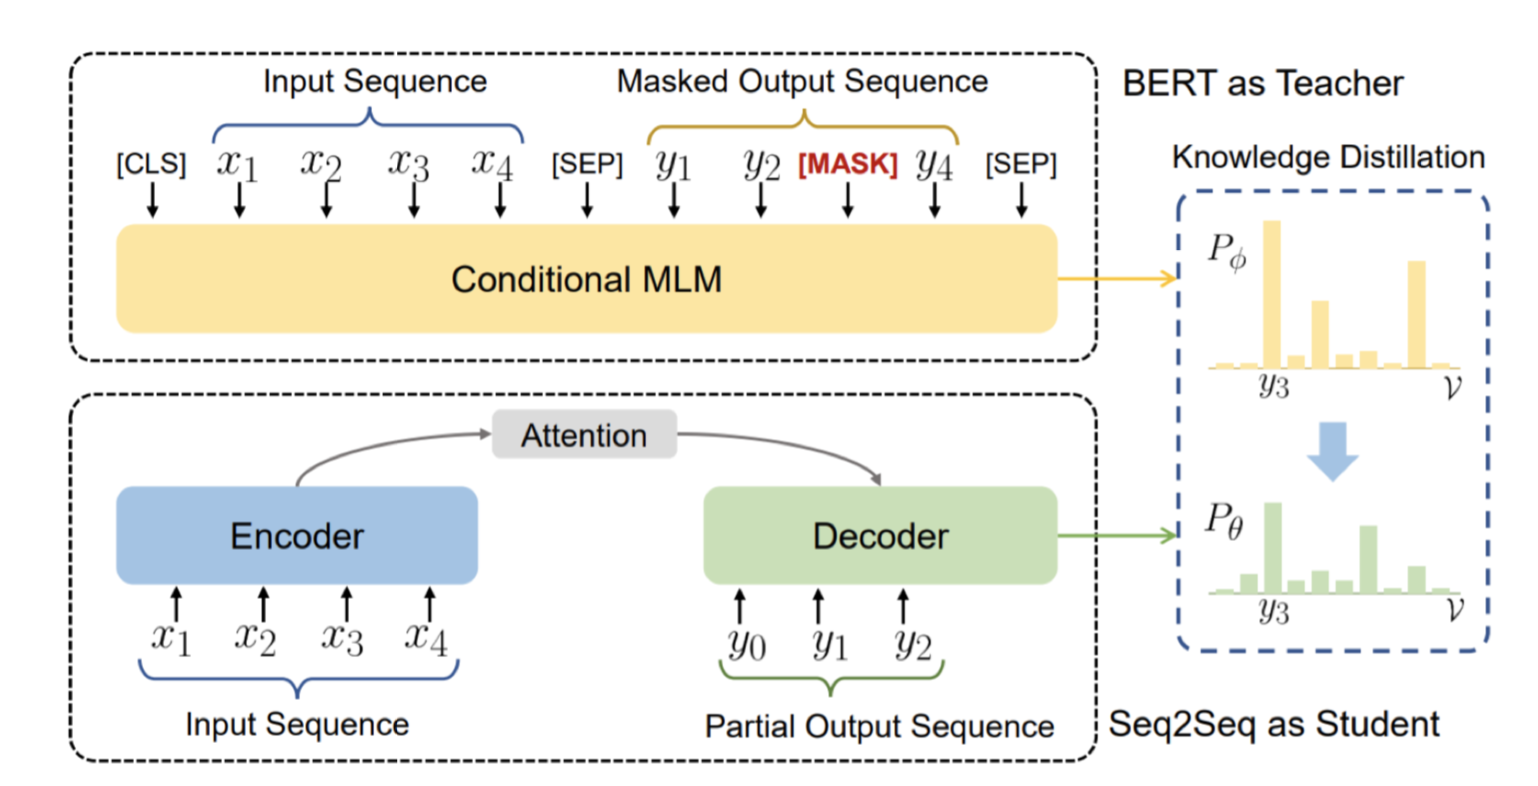

**SEQUENCE-TO-SEQUENCE LEARNING:**
Seq2Seq learning aims to generate a sequence of discrete output Y = (y1,...,yN) of length N, conditioned on a sequence of discrete input X = (x1,...,xM) of length M. A Seq2Seq model learns parameters θ to estimate the conditional likelihood Pθ(Y |X), typically trained via Maximum Likelihood Estimation (MLE), or equivalently, minimizing the cross-entropy loss as follows:


$L_{xe}(\theta)= -\sum_{t=1}^N logP_\theta(y_t=w|y_{1:t-1},x)$

**KNOWLEDGE DISTILLATION FOR GENERATION:** 
    In a knowledge distillation setting, the BERT model can be considered as a teacher, while the Seq2Seq model acts as a student. Specifically, the Seq2Seq model can be trained with the following objective function

$L_{bidi}=-\sum_w[P_{\phi}(y_t=w|y_{unmasked},x).logP_{\theta}(y_t=w|y_{1:t-1},x)]$ 

To further improve the Seq2Seq student model, hard-assigned labels are also utilized. the final model is trained with the following compound objective:

$L_{total}=\alpha L_{xe}+(1-\alpha)L_{bidi}$

In [0]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from tokenizer import * 
from preprocessing import * 
from bert import * 
from encoder import * 
from decoder import * 
from seq2seq import * 
from dataset import * 

In [0]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


Found GPU at: /device:GPU:0


'Tesla P100-PCIE-16GB'

In [0]:
text = "input.txt"
summary = "task1_ref0.txt"

In [0]:
#bert_dataset = BertDataset(text,summary)
#batches_data, token_type_ids, masked_lm_labels = bert_dataset.constract_batches()
# Now we will have to pre_train and fine-tune Bert for text generation task. 
#bertModel = bert_train(inputs= batches_data, token_type_ids = token_type_ids, masked_lm_labels =masked_lm_labels )

In [0]:
#torch.save(bertModel.state_dict(), 'fine_tuned_bert.cpkt')

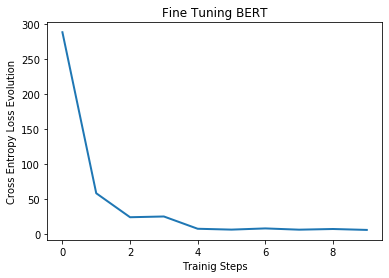

In [0]:
import matplotlib.pyplot as plt
#The printed values are those obtained while trainig BERT. 
""" 
x = np.arange(10)
y = [288.31142577994615,57.97319170215633,23.657384860388902,24.726453930430807,7.157240444591935,5.939065404809298,7.64663550013438,5.854236299765148,6.818541568602541,5.5088135117157435]

plt.plot(x,y, linewidth=2)
plt.title("Fine Tuning BERT")
plt.ylabel("Cross Entropy Loss Evolution")
plt.xlabel("Trainig Steps")
plt.show()
"""

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
bertModel = BertForMaskedLM.from_pretrained('bert-base-uncased')
bertModel.load_state_dict(torch.load('fine_tuned_bert.cpkt'))

<All keys matched successfully>

In [0]:

def train(batch_X, batch_Y, seq2seq, bertModel, seq2seq_optimizer, criterion_xe, criterion_bidi,vocab_size,alpha):
    #print("Debug: - Start Train ")   
    with torch.autograd.set_detect_anomaly(True):
        Loss_xe  = 0
        Loss_bidi = 0 
        Loss = 0 

        seq2seq_optimizer.zero_grad()
      
        batch_size = batch_X.shape[0]
        sequence_length = batch_X.shape[1]
      

        decoder_outputs, _, _  = seq2seq(input_variable= batch_X, target_variable= batch_Y)
        output_seq2seq = torch.stack([x for x in decoder_outputs]) 
    
        output_bert = bert_predict(bertModel, vocab_size, batch_X, batch_Y, 0.15)

        seq2seq_y = output_seq2seq.view(-1, output_seq2seq.shape[2]).to(device)
        #print("seq2seq_y ",seq2seq_y.shape)
      
     
        bert_y =  output_bert[:,1:].reshape(-1).to(device)
        #print("bert_y ",bert_y.shape)
      
     
        target_y = batch_y[:,1:].reshape(-1).to(device)
        #print("target_y ",target_y.shape)

        #the Cross entropy loss of the Seq2Seq Model 
        Loss_xe = Loss_xe + criterion_xe (seq2seq_y, target_y )   
        #print("loss xe ",Loss_xe)
     
        Loss_bidi = Loss_bidi + criterion_bidi (seq2seq_y,bert_y) 
        #print("loss bidi ",Loss_bidi)

        #Knowledge Distilliation:      
        Loss = Loss +   alpha * Loss_bidi +  (1-alpha) * Loss_xe 
        #print("total loss",Loss.item())
        Loss.backward()
        seq2seq_optimizer.step()

    return Loss_xe.item() , Loss_bidi.item(), Loss.item() 
  

In [0]:
"""
hidden_size = 256
vocab_size = 30522 

encoder = EncoderRNN(vocab_size=vocab_size,max_len=100,hidden_size=hidden_size).to(device)
decoder = DecoderRNN(vocab_size=vocab_size,max_len=100,hidden_size=hidden_size ,sos_id=101,eos_id=102).to(device)
seq2seq = Seq2seq(encoder,decoder).to(device)


seq2seq_optimizer = optim.Adam(encoder.parameters(), lr=2)

criterion_xe = nn.CrossEntropyLoss(ignore_index=0)
# cross entropy loss for the seq2seq model 
criterion_bidi = nn.CrossEntropyLoss(ignore_index=0) #for the bert 

bert = bertModel.to(device)


train_dataset = TextDataset(text,summary, batch_size= 4)
train_x, train_y = train_dataset.constract_batches()
n_steps = 100

losses_xe = []
losses_bidi = []
losses= [] 

for i in range(n_steps):
  losses_b_xe = []
  losses_b_bidi = []
  losses_b= [] 
  for batch_x, batch_y in zip (train_x,train_y): 
    l_xe, l_bidi, l = train(batch_x.to(device) , batch_y.to(device), seq2seq, bert, seq2seq_optimizer, criterion_xe, criterion_bidi,vocab_size,alpha=0.1)
    losses_b_xe.append(l_xe)
    losses_b_bidi.append(l_bidi)
    losses_b.append(l)
  losses_xe.append(np.mean(losses_b_xe))
  losses_bidi.append(np.mean(losses_b_bidi))
  losses.append(np.mean(losses_b))
  if i%25 == 0: 
    print(" - Step: ",i, "Loss: ",np.mean(losses_b))
torch.save(seq2seq.state_dict(), 'seq2seq_final_100.cpkt')

"""

100%|██████████| 231508/231508 [00:00<00:00, 1223894.86B/s]


 - Step:  0 Loss:  10.354044339595697
 - Step:  25 Loss:  10.356362611819536
 - Step:  50 Loss:  10.355941338416857
 - Step:  75 Loss:  10.356108622673231


In [13]:
"""
for i in range(100,200):
  for batch_x, batch_y in zip (train_x,train_y): 
    l_xe, l_bidi, l = train(batch_x.to(device) , batch_y.to(device), seq2seq, bert, seq2seq_optimizer, criterion_xe, criterion_bidi,vocab_size,alpha=0.1)
    losses_b_xe.append(l_xe)
    losses_b_bidi.append(l_bidi)
    losses_b.append(l)
  losses_xe.append(np.mean(losses_b_xe))
  losses_bidi.append(np.mean(losses_b_bidi))
  losses.append(np.mean(losses_b))
  if i%25 == 0: 
    print(" - Step: ",i, "Loss: ",np.mean(losses_b))
torch.save(seq2seq.state_dict(), 'seq2seq_final_200.cpkt')
"""

 - Step:  100 Loss:  10.35629080503415
 - Step:  125 Loss:  10.356054964002155
 - Step:  150 Loss:  10.355368090922076
 - Step:  175 Loss:  10.353851296605566


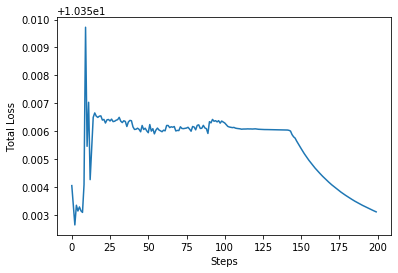

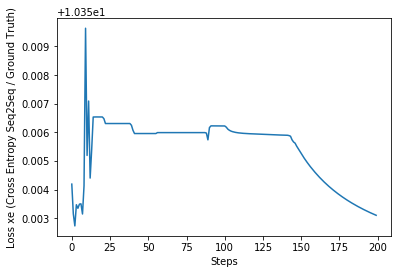

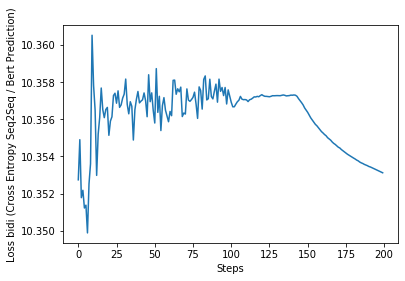

In [14]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(losses)),losses)
plt.xlabel("Steps")
plt.ylabel("Total Loss")
plt.show() 
plt.plot(np.arange(len(losses)),losses_xe)
plt.xlabel("Steps")
plt.ylabel("Loss xe (Cross Entropy Seq2Seq / Ground Truth)")
plt.show() 
plt.plot(np.arange(len(losses)),losses_bidi)
plt.xlabel("Steps")
plt.ylabel("Loss bidi (Cross Entropy Seq2Seq / Bert Prediction)")
plt.show() 

Tests: 

In [0]:
hidden_size = 256
vocab_size = 30522 
encoder = EncoderRNN(vocab_size=vocab_size,max_len=100,hidden_size=hidden_size).to(device)
decoder = DecoderRNN(vocab_size=vocab_size,max_len=100,hidden_size=hidden_size ,sos_id=101,eos_id=102).to(device)
seq2seq = Seq2seq(encoder,decoder).to(device)
seq2seq.load_state_dict(torch.load('seq2seq_final_1000.cpkt'))

In [0]:
text_test = "input2.txt"
summary_test = "task1_ref0_2.txt"


def evaluate_seq2seq(text_test,summary_test,seq2seq): 
    output_text = "predicted_sentences_"+summary_test
    f = open(output_text, "a")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    losses=[]
    seq2seq.eval()
    criterion_seq2seq = nn.CrossEntropyLoss() 

    train_dataset = TextDataset(text_test,summary_test, batch_size= 4)
    train_x, train_y = train_dataset.constract_batches()
    str1 = " "
    for batch_x, batch_y in zip (train_x,train_y): 
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        decoder_outputs, _, _  = seq2seq(input_variable= batch_x, target_variable= batch_y)
        output_seq2seq = torch.stack([x for x in decoder_outputs]) 
        seq2seq_preds = torch.argmax(output_seq2seq.clone(),dim=2)
        seq2seq_preds = seq2seq_preds.reshape(seq2seq_preds.shape[1],seq2seq_preds.shape[0])
        for i in range(4): #batch size 
            s_pred = str1.join(tokenizer.convert_ids_to_tokens(seq2seq_preds[i].tolist()))
            #print(s_pred)
            f.write(s_pred+'\n')
        seq2seq_y = output_seq2seq.view(-1, output_seq2seq.shape[2]).to(device)
        target_y = batch_y[:,1:].reshape(-1).to(device)
        #the Cross entropy loss of the Seq2Seq Model 
        losses.append(criterion_seq2seq (seq2seq_y, target_y ).item())  
    f.close()   
    return losses, (np.mean(losses))

test_losses , mean_test_losses = evaluate_seq2seq(text_test,summary_test)
    



In [0]:
print(mean_test_losses)

10.345747634887696
